# 1. Genetic Algorithm with DEAP #

Подгружаем необходимые библиотеки

In [1]:
from deap import tools, base
from numpy import random as rnd
import numpy as np
from deap import creator
from deap import benchmarks
from deap.algorithms import eaMuPlusLambda
from functools import partial
#Для отрисовки функции
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

## 1.1 Задача поиска экстремума сложной функции

Creator - метафабрика классов позволяющая создавать классы, которые будут удовлетворять потребности ваших эволюционных алгоритмов. 

Note: weights=(-1.0,) - minimization, weights=(1.0,) - maximization

In [2]:
creator.create("BaseFitness", base.Fitness, weights=(-1.0,)) 
creator.create("Individual", np.ndarray, fitness=creator.BaseFitness)

Инициализируем целевую функцию 

In [3]:
optimization_function = benchmarks.rastrigin

Нарисуем ее

In [4]:
def function_drawing(func, limit):

    def function_arg0(selected_function, sol):
        return selected_function(sol)[0]

    function_for_drawing = partial(function_arg0, func)

    fig = plt.figure()
    ax = Axes3D(fig, azim = -29, elev = 40)
    X = np.arange(limit[0], limit[1], 0.5)
    Y = np.arange(limit[0], limit[1], 0.5)
    X, Y = np.meshgrid(X, Y)
    Z = np.fromiter(map(function_for_drawing, zip(X.flat,Y.flat)), dtype=np.float, count=X.shape[0]*X.shape[1]).reshape(X.shape)

    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet, linewidth=0.2)

    plt.xlabel("x")
    plt.ylabel("y")

    plt.show()

In [5]:
dimension = 3
pop_size = 100
iterations = 100
mut_prob = 0.6
cross_prob = 0.3
limit = [-5, 5]

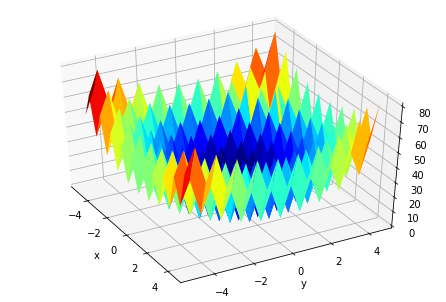

In [6]:
function_drawing(optimization_function, limit)

Зададим параметры нашего жволюционного алгоритма
* dimension - размерность задачи
* pop_size - размер популяции
* iterations - количество поколений 
* mut_prob - вероятность применения оператора мутации
* cross_prob - вероятность применения оператора скрещивания к двум отобранным индивидам
* limit - область поиска по каждой из переменых функции

Функция для инициализации случайного числа из выбранной области определения:

In [7]:
def factory(limit, dimension):
    return limit[0] + rnd.random(dimension) * (limit[1]-limit[0])

In [8]:
class DrawLog:
    @staticmethod
    def read_log(log):
        avg_list, std_list, min_list, max_list, gen_list = [list() for i in range(5)]
        for g in log:
            avg_list.append(g['avg'])
            std_list.append(g['std'])
            min_list.append(g['min'])
            max_list.append(g['max'])
            gen_list.append(g['gen'])
        return np.array(gen_list), np.array(avg_list), np.array(std_list), np.array(max_list), np.array(min_list)
    
    @staticmethod
    def draw_log(log):
        gen_list, avg_list, std_list, max_list, min_list = DrawLog.read_log(log)
        plt.plot(gen_list, avg_list, label="avg")
        plt.plot(gen_list, min_list, label="min")
        plt.plot(gen_list, max_list, label="max")
        plt.fill_between(gen_list, avg_list-std_list, avg_list+std_list, alpha=0.2)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    @staticmethod
    def draw_logs(log1, log2, lab1, lab2):
        gen1, avg1, std1, max1, min1 = DrawLog.read_log(log1)
        gen2, avg2, std2, max2, min2 = DrawLog.read_log(log2)
        plt.plot(gen1, avg1, label=lab1, color="blue")
        plt.plot(gen1, max1, label="{}_max".format(lab1), color="purple", linewidth=2)
        plt.fill_between(gen1, avg1 - std1, avg1 + std1, alpha=0.2, color="blue")
        plt.plot(gen2, avg2, label=lab2, color="orange")
        plt.plot(gen2, max2, label="{}_max".format(lab2), color="red", linewidth=2)
        plt.fill_between(gen2, avg2 - std2, avg2 + std2, alpha=0.2, color="orange")
        plt.ylabel('Fitness')
        plt.xlabel('Generation, #')
        plt.legend()
        plt.tight_layout()
        plt.show()

## Генетический алгоритм реализованный посредствам Deap

Все основные объекты, которые мы будем использовать на нашем пути: индивид, популяция, а также все функции, операторы и аргументы будут храниться в контейнере DEAP с именем Toolbox. 

Он содержит два метода добавления и удаления содержимого register()и unregister().

**В конструкторе класса GeneticAlgorithm** мы регистрируем две функции инициализации individual() и population(). 

Здесь, в inidividual:
* tools.initIterate - инидивид наследуется от какого-то итеративного(iterable) объекта (например list).
* creator.Individual - тип объекта который создается
* ind_gener_func - функция при помощи которой инициализируется случайный объект

В population:
* tools.initRepeat - способ инициализации контейнера популяции
* list - тип контейнера
* toolbox.individual - какой функцией инициализируется объект-индивид
* pop_size - сколько индивидов необходимо создать в популяции

Ниже инициализируются эволюционные операторы.

**В функции run_evolution** происходит создание популяции и определение обсервера – данных для мониторинга, далее происходит запуск эволюционного процесса.

In [9]:
class GeneticAlgorithm:
    def __init__(self, factory, function,  pop_size=50, crossover=tools.cxOnePoint, \
                 mutation=partial(tools.mutGaussian, mu=0, sigma=0.5, indpb=0.2), \
                 selection = partial(tools.selTournament, tournsize=4), 
                limit=limit, dimension=dimension):
        self.toolbox = base.Toolbox()
        self.pop_size = pop_size
        # Structure initializers
        ind_gener_func = partial(factory, limit, dimension)
        self.toolbox.register("individual", tools.initIterate, creator.Individual, ind_gener_func)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual, pop_size)
        #genetic operators
        self.toolbox.register("mate", crossover) #crossover
        self.toolbox.register("mutate", mutation)
        self.toolbox.register("select", selection)
        self.toolbox.register("evaluate",function)
    
    def run_evolution(self, cross_prob, mut_prob, iterations, verbose = True):
        pop = self.toolbox.population() #инициализация начальной популяции
        hof = tools.HallOfFame(3, np.array_equal) #хранятся лучшие решения, архив
        stats = tools.Statistics(lambda ind: ind.fitness.values[0])
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)
        pop, log = eaMuPlusLambda(pop, self.toolbox, mu=self.pop_size, lambda_=int(pop_size*0.8), cxpb=cross_prob, mutpb=mut_prob,
                              ngen=iterations, stats=stats, halloffame=hof, verbose=True)
        print("Best individual = {}".format(hof[0]))
        print("Best fitness = {}".format(hof[0].fitness.values[0]))
        if verbose:
            DrawLog.draw_log(log)
        return pop, log

Инициализация генетического алгоритма

In [10]:
ga = GeneticAlgorithm(factory, optimization_function, pop_size)

Запуск генетического алгоритма

gen	nevals	avg    	std   	min    	max    
0  	100   	55.7782	18.221	13.2397	95.6297
1  	74    	37.769 	10.8514	13.2397	62.0479
2  	72    	25.1549	8.34954	11.8628	44.8944
3  	71    	17.0891	4.86054	8.58033	36.5924
4  	63    	13.052 	2.88298	8.58033	19.7086
5  	74    	10.2391	2.28156	3.45221	16.5719
6  	73    	8.00511	1.92735	3.45221	13.2397
7  	78    	5.5773 	2.08457	3.09075	8.63827
8  	75    	3.66046	0.864045	1.32618	7.91739
9  	72    	3.12496	0.552589	1.32618	3.45221
10 	77    	2.56446	0.841297	1.32618	3.45221
11 	68    	1.88391	0.801572	1.32618	3.09075
12 	71    	1.38704	0.300266	1.32618	3.09075
13 	78    	1.32725	0.136197	1.04954	2.55501
14 	66    	1.26198	0.108527	1.04954	1.32618
15 	67    	1.14919	0.117426	1.04954	1.32618
16 	72    	1.06116	0.0302161	1.04954	1.30632
17 	71    	1.03792	0.0678375	0.65327	1.09654
18 	71    	0.993861	0.137434 	0.65327	1.04954
19 	77    	0.899953	0.215439 	0.128608	1.04954
20 	76    	0.716497	0.223379 	0.128608	1.04954
21 	71    	0.552101	0.215025 	0.1

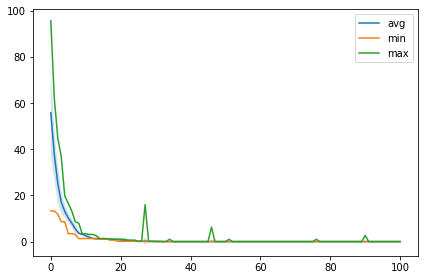

In [11]:
population, log = ga.run_evolution(cross_prob, mut_prob, iterations)

Протестируем наш алгоритм на другой функции.

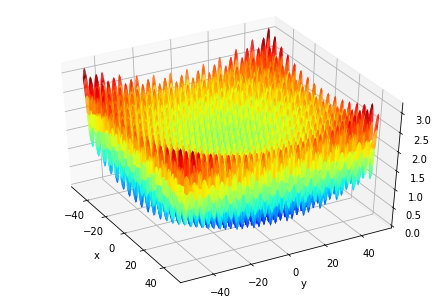

In [12]:
iterations = 200
pop_size = 200
mut_prob = 0.9
cross_prob = 0.1
optimization_function = benchmarks.griewank
function_drawing(optimization_function, limit=[-50, 50])

gen	nevals	avg    	std     	min     	max    
0  	200   	1.03316	0.328453	0.164017	1.99478
1  	160   	0.696688	0.258195	0.13899 	1.11793
2  	160   	0.412167	0.203733	0.0904632	0.894577
3  	160   	0.222134	0.119921	0.0764742	0.653384
4  	160   	0.125207	0.0488983	0.0480646	0.376092
5  	160   	0.0864272	0.0213782	0.0397028	0.142423
6  	160   	0.0633681	0.0195279	0.0282531	0.110654
7  	160   	0.044067 	0.0125039	0.0160162	0.0904632
8  	160   	0.0321292	0.0094627	0.0160162	0.0544028
9  	160   	0.0237206	0.00732724	0.0087546	0.0424226
10 	160   	0.0165576	0.00433225	0.0087546	0.0290903
11 	160   	0.0128819	0.00344308	0.00761935	0.0204006
12 	160   	0.00971846	0.00191209	0.00761935	0.0160162
13 	160   	0.00869438	0.00042347	0.00761935	0.00963292
14 	160   	0.00836094	0.000457947	0.00761935	0.00891331
15 	160   	0.00801562	0.000429695	0.00742549	0.00876833
16 	160   	0.00769366	0.000202111	0.00742549	0.00851613
17 	160   	0.00762281	4.73533e-05	0.00742549	0.00801295
18 	160   	0.00770587	0.001

149	160   	0.00739674	4.75442e-09	0.00739674	0.00739679
150	160   	0.00739674	0          	0.00739674	0.00739674
151	160   	0.00739674	0          	0.00739674	0.00739674
152	160   	0.00739674	0          	0.00739674	0.00739674
153	160   	0.00739674	0          	0.00739674	0.00739674
154	160   	0.00739674	0          	0.00739674	0.00739674
155	160   	0.00739674	0          	0.00739674	0.00739674
156	160   	0.00739674	0          	0.00739674	0.00739674
157	160   	0.0074247 	0.00039434 	0.00739674	0.0129876 
158	160   	0.00739674	0          	0.00739674	0.00739674
159	160   	0.00739674	0          	0.00739674	0.00739674
160	160   	0.00741235	0.000220101	0.00739674	0.0105173 
161	160   	0.0074637 	0.000944518	0.00739674	0.0207878 
162	160   	0.00739674	0          	0.00739674	0.00739674
163	160   	0.00739674	0          	0.00739674	0.00739674
164	160   	0.00739674	0          	0.00739674	0.00739674
165	160   	0.00739674	0          	0.00739674	0.00739674
166	160   	0.00747276	0.00107239 	0.00739674	0.0

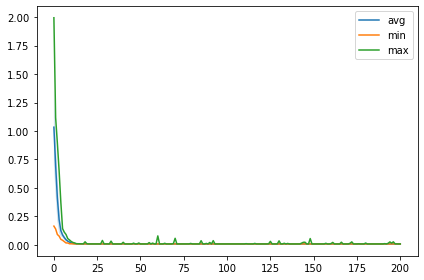

In [13]:
ga = GeneticAlgorithm(factory, optimization_function, pop_size)
population, log = ga.run_evolution(cross_prob, mut_prob, iterations)

Увеличим область поиска

gen	nevals	avg    	std     	min      	max    
0  	200   	1.01109	0.358037	0.0543585	1.94549
1  	160   	0.615507	0.294514	0.0543585	1.29549
2  	160   	0.329133	0.17335 	0.0131305	1.01163
3  	160   	0.191185	0.08    	0.0131305	0.356056
4  	160   	0.108058	0.064595	0.0131305	0.22941 
5  	160   	0.0517967	0.0263243	0.0131305	0.154878
6  	160   	0.0313283	0.0165793	0.0113685	0.072602
7  	160   	0.0176498	0.0100665	0.0113685	0.0567745
8  	160   	0.0128969	0.00237959	0.0111991	0.0389123
9  	160   	0.0118309	0.000680592	0.0110878	0.0131305
10 	160   	0.0113079	0.000282048	0.00918134	0.0119872
11 	160   	0.0110363	0.000505739	0.00918134	0.0113685
12 	160   	0.0105211	0.000864611	0.0077438 	0.0126183
13 	160   	0.0097483	0.000859909	0.0077438 	0.0111991
14 	160   	0.00894457	0.000703401	0.0077438 	0.0101628
15 	160   	0.00836443	0.00069674 	0.00749485	0.00986663
16 	160   	0.00782369	0.000391031	0.00742857	0.00918134
17 	160   	0.00768361	0.000968181	0.00742857	0.0212101 
18 	160   	0.00749549	9

181	160   	0.00739604	0          	0.00739604	0.00739604
182	160   	0.00758643	0.0026857  	0.00739604	0.0454729 
183	160   	0.00740151	7.7036e-05 	0.00739604	0.00848823
184	160   	0.00739604	0          	0.00739604	0.00739604
185	160   	0.00739604	0          	0.00739604	0.00739604
186	160   	0.00739604	0          	0.00739604	0.00739604
187	160   	0.00743222	0.000486495	0.00739604	0.0142865 
188	160   	0.00739604	0          	0.00739604	0.00739604
189	160   	0.00739604	0          	0.00739604	0.00739604
190	160   	0.00743678	0.000574595	0.00739604	0.0155424 
191	160   	0.00739617	1.76422e-06	0.00739604	0.00742106
192	160   	0.00746557	0.000980742	0.00739604	0.0213006 
193	160   	0.00740607	0.000135211	0.00739604	0.00931133
194	160   	0.00739604	0          	0.00739604	0.00739604
195	160   	0.00743095	0.000414551	0.00739604	0.0131501 
196	160   	0.00739656	7.20838e-06	0.00739604	0.00749824
197	160   	0.00739604	0          	0.00739604	0.00739604
198	160   	0.00742779	0.000320049	0.00739604	0.0

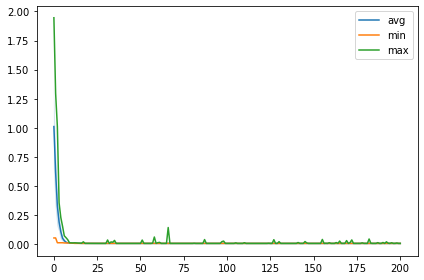

In [14]:
limit = [-100, 100]
ga = GeneticAlgorithm(factory, optimization_function, pop_size)
population, log = ga.run_evolution(cross_prob, mut_prob, iterations)

При увеличении размерности задачи так же будет наблюдаться ухудшение качества поиска. Это означает то, что в данном случае требуется задать другие более подходящие гиперпараметры (в первую очередь увеличить размер популяции и количество поколений для поиска), что позволит получить хорошее решение в изменившихся условиях.

gen	nevals	avg    	std      	min     	max    
0  	700   	1.02048	0.0190644	0.773551	1.17275
1  	560   	1.01027	0.0158963	0.863608	1.0299 
2  	560   	0.994204	0.0263659	0.863608	1.01779
3  	560   	0.969949	0.038236 	0.721924	1.01165
4  	560   	0.926077	0.0529   	0.562243	0.999268
5  	560   	0.87021 	0.0657256	0.450215	0.973061
6  	560   	0.801566	0.0944951	0.422702	0.929848
7  	560   	0.698093	0.123559 	0.314436	0.865981
8  	560   	0.56443 	0.105937 	0.314436	0.842787
9  	560   	0.464253	0.0664712	0.307503	0.68341 
10 	560   	0.394423	0.058291 	0.194714	0.555221
11 	560   	0.333919	0.0533979	0.166002	0.499825
12 	560   	0.28609 	0.0422887	0.164341	0.391824
13 	560   	0.24235 	0.0424528	0.109784	0.325575
14 	560   	0.201051	0.0316745	0.109784	0.299173
15 	560   	0.16936 	0.0249236	0.104562	0.24788 
16 	560   	0.147459	0.0226304	0.0898044	0.295501
17 	560   	0.125503	0.0183743	0.0751455	0.179617
18 	560   	0.108072	0.0165189	0.0585172	0.206866
19 	560   	0.0937857	0.0145379	0.0440212	0.15

159	560   	0.0124937	0.00287115 	0.0123219	0.0828712
160	560   	0.0124599	0.00196318 	0.0123216	0.0516911
161	560   	0.0125362	0.00245522 	0.0123215	0.0551985
162	560   	0.0126339	0.00462171 	0.0123215	0.115641 
163	560   	0.0125007	0.0023495  	0.0123215	0.0621856
164	560   	0.0124983	0.00144221 	0.0123215	0.0336177
165	560   	0.0125168	0.00291344 	0.0123215	0.0850107
166	560   	0.0125462	0.0025405  	0.0123215	0.0661405
167	560   	0.0125132	0.00223501 	0.0123215	0.0471286
168	560   	0.0124407	0.00119422 	0.0123215	0.0327344
169	560   	0.0124767	0.00195283 	0.0123215	0.0534451
170	560   	0.0124607	0.0015871  	0.0123215	0.0465085
171	560   	0.0125506	0.00301221 	0.0123215	0.0623463
172	560   	0.0125844	0.00243528 	0.0123215	0.0464833
173	560   	0.0126282	0.00302125 	0.0123215	0.0595855
174	560   	0.0124891	0.0017083  	0.0123215	0.0374484
175	560   	0.0123606	0.000597423	0.0123215	0.0263436
176	560   	0.0124866	0.00245221 	0.0123215	0.0701281
177	560   	0.0124594	0.00151139 	0.0123215	0.0

322	560   	0.0124763	0.00195926 	0.012321 	0.0465991
323	560   	0.0123743	0.00080633 	0.012321 	0.0300947
324	560   	0.0124889	0.00229898 	0.012321 	0.0591067
325	560   	0.0124758	0.00254163 	0.012321 	0.0633753
326	560   	0.0126   	0.00294893 	0.012321 	0.0545706
327	560   	0.0125201	0.00222839 	0.012321 	0.0537373
328	560   	0.0126934	0.00430571 	0.012321 	0.0914669
329	560   	0.0124551	0.00207781 	0.012321 	0.0641708
330	560   	0.0125267	0.00319905 	0.012321 	0.0866471
331	560   	0.0124717	0.00202146 	0.012321 	0.0579091
332	560   	0.0124699	0.00142301 	0.012321 	0.039162 
333	560   	0.0126829	0.00301647 	0.012321 	0.0530628
334	560   	0.0127031	0.00367691 	0.012321 	0.0723678
335	560   	0.0127029	0.00433126 	0.012321 	0.0927395
336	560   	0.0124153	0.0010403  	0.012321 	0.0346281
337	560   	0.0126191	0.0036059  	0.012321 	0.0729345
338	560   	0.0124746	0.00225129 	0.012321 	0.0635204
339	560   	0.0125305	0.00278282 	0.012321 	0.0765712
340	560   	0.0125294	0.00235924 	0.012321 	0.0

484	560   	0.0124898	0.00203478 	0.012321 	0.0453034
485	560   	0.012563 	0.00233361 	0.012321 	0.0477233
486	560   	0.0124247	0.0018641  	0.012321 	0.0594048
487	560   	0.0125106	0.00175647 	0.012321 	0.0397947
488	560   	0.0124063	0.000744292	0.012321 	0.0220868
489	560   	0.0125475	0.00283129 	0.012321 	0.0710252
490	560   	0.0123761	0.000669913	0.012321 	0.0255717
491	560   	0.0126144	0.00353784 	0.012321 	0.0748481
492	560   	0.0124798	0.00179013 	0.012321 	0.0503801
493	560   	0.0126501	0.00420543 	0.012321 	0.107293 
494	560   	0.0126304	0.00352187 	0.012321 	0.0807225
495	560   	0.0124925	0.00147026 	0.012321 	0.0280269
496	560   	0.0125022	0.00229037 	0.012321 	0.0515648
497	560   	0.0125707	0.00266668 	0.012321 	0.0699932
498	560   	0.0124886	0.00198518 	0.012321 	0.0562976
499	560   	0.0125416	0.0025948  	0.012321 	0.0660758
500	560   	0.0124593	0.00234209 	0.012321 	0.0687477
501	560   	0.0125334	0.00298998 	0.012321 	0.0716724
502	560   	0.0125775	0.0037776  	0.012321 	0.1

649	560   	0.0123519	0.000545697	0.012321 	0.0226833
650	560   	0.0124349	0.00182961 	0.012321 	0.0589802
651	560   	0.0126167	0.00264918 	0.012321 	0.0532121
652	560   	0.0125739	0.00262149 	0.012321 	0.0580887
653	560   	0.0125976	0.0036606  	0.012321 	0.100246 
654	560   	0.0125271	0.00223806 	0.012321 	0.0551137
655	560   	0.0124588	0.00158096 	0.012321 	0.0483435
656	560   	0.012604 	0.00311223 	0.012321 	0.0823996
657	560   	0.0126027	0.00296912 	0.012321 	0.0690824
658	560   	0.0126237	0.00319149 	0.012321 	0.0730433
659	560   	0.0125974	0.00293691 	0.012321 	0.0608804
660	560   	0.0124729	0.00167889 	0.012321 	0.0397568
661	560   	0.0125317	0.00245744 	0.012321 	0.0624704
662	560   	0.0125822	0.00275569 	0.012321 	0.0715817
663	560   	0.0126487	0.00298187 	0.012321 	0.0505582
664	560   	0.0126569	0.00464318 	0.012321 	0.125902 
665	560   	0.0125302	0.00210135 	0.012321 	0.0531973
666	560   	0.0124612	0.00134953 	0.012321 	0.0376331
667	560   	0.0124233	0.00221847 	0.012321 	0.0

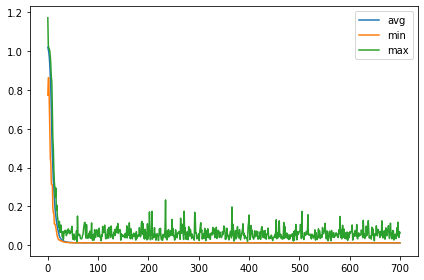

In [15]:
limit = [-5, 5]
dimension = 10
iterations = 700
pop_size = 700
ga = GeneticAlgorithm(factory, optimization_function, pop_size, limit=limit, dimension=dimension)
population, log = ga.run_evolution(cross_prob, mut_prob, iterations)

Мы можем воспользоваться другими генетическими операторами из Deap. 
**Попробуем задать другую функцию скрещивания.**

gen	nevals	avg    	std      	min     	max    
0  	700   	1.02111	0.0150729	0.875226	1.15956
1  	560   	1.00872	0.0201638	0.875226	1.02978
2  	560   	0.990626	0.0291738	0.875226	1.01913
3  	560   	0.956039	0.0348403	0.852164	1.01413
4  	560   	0.920712	0.0280129	0.809502	0.993596
5  	560   	0.888321	0.0297417	0.655567	0.948745
6  	560   	0.848815	0.0465058	0.551263	0.907946
7  	560   	0.80401 	0.0683709	0.444704	0.88345 
8  	560   	0.728916	0.0878397	0.444704	0.862849
9  	560   	0.627357	0.089289 	0.310223	0.806255
10 	560   	0.536243	0.0628569	0.310223	0.717282
11 	560   	0.466054	0.066429 	0.226832	0.59898 
12 	560   	0.399332	0.0645417	0.221346	0.537786
13 	560   	0.330892	0.0541654	0.186653	0.466418
14 	560   	0.27908 	0.0385019	0.131892	0.385175
15 	560   	0.236137	0.0382538	0.126417	0.349652
16 	560   	0.196401	0.0358981	0.105093	0.290482
17 	560   	0.162516	0.0304538	0.0685233	0.248402
18 	560   	0.13532 	0.0224106	0.0725085	0.220355
19 	560   	0.114243	0.0185499	0.0574389	0.1687

158	560   	0.00775092	0.00340145 	0.00739936	0.0734955 
159	560   	0.00762353	0.00286737 	0.0073993 	0.0557742 
160	560   	0.00752594	0.00162696 	0.00739894	0.0315976 
161	560   	0.00780706	0.00477243 	0.00739863	0.110772  
162	560   	0.00771573	0.00325082 	0.00739863	0.061202  
163	560   	0.00759565	0.00201722 	0.00739863	0.0387719 
164	560   	0.00762854	0.00252036 	0.00739863	0.0516637 
165	560   	0.00754379	0.00183031 	0.00739819	0.0401048 
166	560   	0.00765729	0.00294414 	0.00739819	0.074901  
167	560   	0.00747835	0.0012341  	0.00739819	0.0343475 
168	560   	0.00754328	0.00132118 	0.00739819	0.0243682 
169	560   	0.00755427	0.00170011 	0.00739813	0.0409659 
170	560   	0.00763317	0.002742   	0.00739813	0.0500434 
171	560   	0.00759259	0.00189561 	0.00739813	0.0441689 
172	560   	0.00752255	0.0015792  	0.00739813	0.0348881 
173	560   	0.00766567	0.0029037  	0.00739813	0.066322  
174	560   	0.00767324	0.00221712 	0.0073974 	0.0347302 
175	560   	0.00762134	0.00177556 	0.00739704	0.0

313	560   	0.00761705	0.00276238 	0.00739616	0.0737483 
314	560   	0.00744776	0.000699107	0.00739616	0.019766  
315	560   	0.00748579	0.00128903 	0.00739616	0.0371248 
316	560   	0.007558  	0.00206349 	0.00739616	0.0503936 
317	560   	0.00751824	0.00151746 	0.00739616	0.0422766 
318	560   	0.0076686 	0.00237636 	0.00739616	0.0420996 
319	560   	0.00761392	0.00238901 	0.00739616	0.0444434 
320	560   	0.00766147	0.00263999 	0.00739616	0.0508232 
321	560   	0.00768135	0.00436222 	0.00739616	0.118577  
322	560   	0.00764723	0.00320688 	0.00739616	0.0651107 
323	560   	0.007732  	0.00418574 	0.00739616	0.0832414 
324	560   	0.00774426	0.00324423 	0.00739616	0.0645764 
325	560   	0.00761255	0.00204195 	0.00739616	0.0439423 
326	560   	0.00768255	0.00272103 	0.00739616	0.0512615 
327	560   	0.00760519	0.00281385 	0.00739616	0.068856  
328	560   	0.0075837 	0.0018974  	0.00739616	0.0394655 
329	560   	0.00762683	0.00237674 	0.00739616	0.0428053 
330	560   	0.00758288	0.00240281 	0.00739616	0.0

467	560   	0.0075987 	0.00250187 	0.00739606	0.0663494 
468	560   	0.00754846	0.00290035 	0.00739606	0.082818  
469	560   	0.00765006	0.0027854  	0.00739606	0.0550935 
470	560   	0.0074833 	0.0013825  	0.00739606	0.041882  
471	560   	0.00760448	0.00284449 	0.00739606	0.0610689 
472	560   	0.00781795	0.00398062 	0.00739606	0.0780686 
473	560   	0.00746552	0.001125   	0.00739606	0.0348088 
474	560   	0.0076238 	0.00251081 	0.00739606	0.0548758 
475	560   	0.007597  	0.00199932 	0.00739606	0.0352879 
476	560   	0.00748701	0.00132568 	0.00739606	0.0354831 
477	560   	0.00759901	0.00346748 	0.00739606	0.0938389 
478	560   	0.00749532	0.00111089 	0.00739606	0.0249056 
479	560   	0.00775322	0.00370693 	0.00739606	0.0812091 
480	560   	0.00744198	0.000647605	0.00739606	0.0219952 
481	560   	0.00757419	0.00175868 	0.00739606	0.0347127 
482	560   	0.00752556	0.00166887 	0.00739606	0.0370953 
483	560   	0.00756512	0.0017467  	0.00739606	0.041767  
484	560   	0.00749004	0.00090328 	0.00739606	0.0

615	560   	0.00770407	0.00322688 	0.00739605	0.0524173 
616	560   	0.00763439	0.00210353 	0.00739605	0.0434876 
617	560   	0.00758113	0.00191672 	0.00739605	0.0414641 
618	560   	0.00744456	0.000697274	0.00739605	0.0228721 
619	560   	0.00769356	0.00286749 	0.00739605	0.0550106 
620	560   	0.00780643	0.00488813 	0.00739605	0.1213    
621	560   	0.00758986	0.0019964  	0.00739605	0.0416752 
622	560   	0.00759915	0.00228745 	0.00739605	0.0496453 
623	560   	0.00768216	0.00403623 	0.00739605	0.10345   
624	560   	0.00753606	0.00149019 	0.00739605	0.031382  
625	560   	0.00773791	0.00358891 	0.00739605	0.0763498 
626	560   	0.0075649 	0.00156449 	0.00739605	0.0316842 
627	560   	0.0076728 	0.00348631 	0.00739605	0.0837931 
628	560   	0.00775096	0.00438407 	0.00739605	0.0972659 
629	560   	0.00748498	0.00119235 	0.00739605	0.0343005 
630	560   	0.00762994	0.00332643 	0.00739605	0.0882334 
631	560   	0.00767101	0.00262429 	0.00739605	0.0558142 
632	560   	0.00760513	0.00197863 	0.00739605	0.0

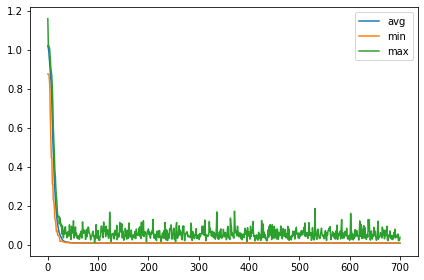

In [16]:
#выберем двухточеченое скрещивание
crossover = tools.cxTwoPoint
ga = GeneticAlgorithm(factory, optimization_function, pop_size, crossover = crossover, dimension=dimension)
population, log = ga.run_evolution(cross_prob, mut_prob, iterations)

## Использование собственных генетических операторов.

Реализация собственного оператора мутации

In [17]:
def Mymutation(individual):
    n = len(individual)
    for i in range(n):
        if rnd.random() < n * 0.15:
            individual[i] += rnd.normal(0.0, 0.2)
            individual[i] = np.clip(individual[i], -5, 5)
    return individual,

Передадим его в алгоритм в качестве параметра

gen	nevals	avg   	std    	min     	max    
0  	300   	1.0162	0.13346	0.451236	1.75768
1  	240   	0.891938	0.131082	0.451236	1.03252
2  	240   	0.75489 	0.137182	0.378674	0.997683
3  	240   	0.590644	0.121662	0.323616	0.91607 
4  	240   	0.448005	0.0944272	0.232186	0.6653  
5  	240   	0.347946	0.0691592	0.0487551	0.547554
6  	240   	0.272204	0.0671436	0.0487551	0.411994
7  	240   	0.197105	0.0594366	0.0487551	0.362782
8  	240   	0.140617	0.0466498	0.0487551	0.255689
9  	240   	0.0956936	0.0333333	0.027937 	0.207304
10 	240   	0.066031 	0.0224196	0.0222441	0.141845
11 	240   	0.0464976	0.0150151	0.0106404	0.109085
12 	240   	0.0346146	0.0103597	0.0106404	0.0713753
13 	240   	0.0249686	0.00748939	0.00825903	0.0487551
14 	240   	0.0187443	0.0056544 	0.00500039	0.0462598
15 	240   	0.0139328	0.00527091	0.00349466	0.0557806
16 	240   	0.0104285	0.00405508	0.00190453	0.024372 
17 	240   	0.00809169	0.00439109	0.00190453	0.0538632
18 	240   	0.00607424	0.00316172	0.00190453	0.0312588
19 	240  

156	240   	0.000389096	0.00246641 	5.73932e-06	0.0260472 
157	240   	0.000299779	0.00221379 	5.73932e-06	0.0239584 
158	240   	0.000340333	0.00250308 	5.73932e-06	0.0326673 
159	240   	0.00016613 	0.00160412 	5.73932e-06	0.0256147 
160	240   	0.000128519	0.00110655 	5.73932e-06	0.0132975 
161	240   	0.000445648	0.00259125 	5.73932e-06	0.0241781 
162	240   	0.000502941	0.00356794 	5.73932e-06	0.0404213 
163	240   	0.000126209	0.00103949 	5.73932e-06	0.0136783 
164	240   	0.000263062	0.00180631 	5.73932e-06	0.0197368 
165	240   	0.000402081	0.00249072 	5.73932e-06	0.0237386 
166	240   	0.000201766	0.00156629 	5.73932e-06	0.016664  
167	240   	0.000348182	0.00258303 	5.73932e-06	0.0290969 
168	240   	9.9733e-05 	0.000696358	5.73932e-06	0.00729473
169	240   	0.000200524	0.00155747 	5.73932e-06	0.0216542 
170	240   	0.00051016 	0.00327859 	5.73932e-06	0.0430122 
171	240   	0.000333026	0.00229826 	5.73932e-06	0.0264228 
172	240   	0.000492048	0.00337645 	5.73932e-06	0.0462151 
173	240   	0.0

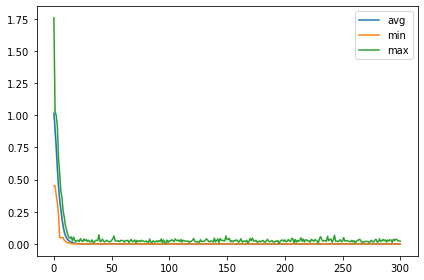

In [18]:
iterations = 300
pop_size = 300
ga = GeneticAlgorithm(factory, optimization_function, pop_size, mutation = Mymutation, dimension=5)
population, log = ga.run_evolution(cross_prob, mut_prob, iterations)

Отлично! Перейдем к следующему разделу

## 1.2 Задача о рюкзаке

**Условие**: из заданного множества предметов со свойствами «стоимость» и «вес» требуется отобрать подмножество с максимальной полной стоимостью, соблюдая при этом ограничение на суммарный вес.

In [19]:
import random
from deap import algorithms

**Инициализация основных параметров/ограничений задачи**
* ind_init_size - количество предметов с которым инициализируются индивиды начальной популяции
* max_item - максимальное количество предметов в рюкзаке
* max_weight - максимальный вес рюкзака
* num_of_items - количество различных предметов

In [20]:
ind_init_size = 5
max_item = 50
max_weight = 50
num_of_items = 20

In [21]:
creator.create("KnapsackFitness", base.Fitness, weights=(-1.0, 1.0))
creator.create("KnapsackIndividual", set, fitness=creator.KnapsackFitness)

Теперь у вас есть индивиды (которые по сути являются множествами из предметов). 

У каждого из них можно оценить fitness. 

В данном случае цель - это минимизация первой цели (веса мешка) и максимизация второй цели (ценность мешка). 

Мы имеем дело с *многокритериальной задачей комбинаторной оптимизации*.

Теперь мы создадим словарь из 20 случайных предметов, которые и будем складывать в рюкзак:

In [22]:
# Create the item dictionary: item name is an integer, and value is 
# a (weight, value) 2-uple.
items = {}
# Create random items and store them in the items' dictionary.
for i in range(num_of_items):
    items[i] = (random.randint(1, 10), random.uniform(0, 100))

Определим **функцию оценки индивида**.

Здесь рассчитывается суммарный вес и суммарная стоимость (не забываем, что у нас два objectiv-а).

In [23]:
def evalKnapsack(individual):
    weight = 0.0
    value = 0.0
    for item in individual:
        weight += items[item][0]
        value += items[item][1]
    if len(individual) > max_item or weight > max_weight:
        return 10000, 0             # Ensure overweighted bags are dominated
    return weight, value

В Deap нет операторов кроссовера и мутации, которые можно было бы применять непосредственно к наборам. Поэтому придется ввети свои.

**Функция скрещивания**

Определим простой вариант скрещивания порождающий двух детей от двух родителей. И в нашем случае первый ребенок будет получаться пересечением двух множеств, а второй ребенок - их разницей.

Однако для того чтобы не получались пустые индивиды, необходимо прописать некоторые дополнительные условия.

In [24]:
def cxSet(ind1, ind2):
    """Apply a crossover operation on input sets. The first child is the
    intersection of the two sets, the second child is the difference of the
    two sets.
    """
    temp = set(ind1)                # Used in order to keep type
    temp2 = set(ind2)
    ind1 &= ind2                    # Intersection (inplace)
    ind2 ^= temp                    # Symmetric Difference (inplace)x
    if len(ind1) == 0:
        ind1.add(temp.pop())
    if len(ind2) == 0:
        ind2.add(temp2.pop())
    return ind1, ind2

**Оператор мутации** будет случайным образом добавлять или удалять элемент из набора.

In [25]:
def mutSet(individual):
    """Mutation that pops or add an element."""
    if random.random() < 0.5:
        if len(individual) > 1:     # We cannot pop from an empty set
            individual.remove(random.choice(sorted(tuple(individual))))
    else:
        individual.add(random.randrange(num_of_items))
    return individual,

Затем мы регистрируем эти операторы в панели инструментов. 

Поскольку это **многокритериальная задача**, мы выбрали схему выбора **NSGA-II**: selNSGA2()

In [26]:
class NSGA2():
    def __init__(self, evaluation, crossover, mutation):
        self.toolbox = base.Toolbox()
        # Attribute generator
        self.toolbox.register("attr_item", random.randrange, num_of_items)
        # Structure initializers
        self.toolbox.register("individual", tools.initRepeat, creator.KnapsackIndividual, self.toolbox.attr_item, ind_init_size)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        self.toolbox.register("evaluate", evaluation)
        self.toolbox.register("mate", cxSet)
        self.toolbox.register("mutate", mutSet)
        self.toolbox.register("select", tools.selNSGA2)
    def run(self):
        random.seed(64)
        NGEN = 50
        MU = 50
        LAMBDA = 100
        CXPB = 0.5
        MUTPB = 0.3

        pop = self.toolbox.population(n=MU)
        hof = tools.ParetoFront()
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean, axis=0)
        stats.register("std", np.std, axis=0)
        stats.register("min", np.min, axis=0)
        stats.register("max", np.max, axis=0)

        algorithms.eaMuPlusLambda(pop, self.toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats,
                                  halloffame=hof)

        return pop, stats, hof

In [27]:
pop, stats, hof =NSGA2(evaluation = evalKnapsack, crossover = cxSet, mutation = mutSet).run()

gen	nevals	avg                      	std                      	min                        	max                      
0  	50    	[ 25.        278.9552317]	[ 6.40312424 79.30420967]	[ 10.         139.86309578]	[ 35.        435.2205981]
1  	76    	[ 14.58       254.94921739]	[  9.23057961 131.87735796]	[2.         2.84489443]    	[ 36.        435.2205981]
2  	76    	[ 12.88       264.22672183]	[  8.80826884 133.76012719]	[ 1.         71.52483505]  	[ 32.         451.31150655]
3  	79    	[  8.54       217.22991164]	[  8.1515888  145.81875541]	[ 1.         71.52483505]  	[ 32.         524.86119532]
4  	77    	[  9.42     243.442068]    	[  8.44769791 154.62196615]	[ 1.         71.52483505]  	[ 32.         524.86119532]
5  	79    	[  9.24       248.74794633]	[  8.42510534 152.49658781]	[ 1.         71.52483505]  	[ 32.         524.86119532]
6  	75    	[  9.76       246.67258141]	[  9.52797985 163.21293626]	[ 1.         71.52483505]  	[ 32.         524.86119532]
7  	80    	[ 10.9       284.56

Найденное множество Парето

In [28]:
for ind in hof:
    print(*ind)

11
4
11 4
16 4
16 11 4
8 16 11 4
16 11 19 4
16 1 11 4
4 8 11 16 19
4 11 15 16 19
1 4 11 16 19
4 7 11 16 19
1 4 8 11 16 19
4 7 8 11 16 19
4 7 11 15 16 19
1 4 7 11 16 19
4 7 8 11 15 16 19
1 4 7 8 11 16 19
1 4 7 11 15 16 19
1 4 7 8 11 15 16 19
1 4 7 8 9 11 16 19
1 4 7 9 11 15 16 19
1 4 7 8 9 11 15 16 19
1 4 7 8 11 13 15 16 19
1 4 7 8 9 11 15 16 18 19
1 4 5 7 8 11 15 16 18 19
1 4 7 9 11 13 15 16 19
1 4 7 8 9 11 13 15 16 18
1 4 7 9 11 13 15 16 18 19
1 4 7 8 9 11 13 15 16 18 19
1 4 5 7 8 11 13 15 16 18 19
1 4 5 6 7 8 9 11 15 16 18 19
1 4 5 7 8 9 11 13 16 18 19
1 4 5 7 9 11 13 15 16 18 19
1 4 5 7 8 9 11 13 15 16 18 19


## 2. Метод роя частиц (PSO) реализованный посредствам Deap

In [29]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Particle", np.ndarray, fitness=creator.BaseFitness, speed=None, smin=None, smax=None, best=None)

* particle_generation - функция инициализации нового индивида

На начальном этапе сам индивид случайным образом инициализируется со случайной скоростью.

* updateParticle - служит для обновления скорости и позиции индивида

In [30]:
class PSOAlgorithm:
    
    def generate(self):
        return rnd.uniform(self.pmin, self.pmax, self.dimension)

    def particle_generation(self):
        particle = tools.initIterate(creator.Particle, self.generate)
        particle.speed = rnd.uniform(self.smin, self.smax, self.dimension)
        particle.smin = self.smin
        particle.smax = self.smax
        return particle

    def updateParticle(self, part, global_best):
        v1 = (part.best - part) * rnd.uniform(0, self.c1)
        v2 = (global_best - part) * rnd.uniform(0, self.c2)
        part.speed = np.clip(part.speed * self.w + v1 + v2, self.smin, self.smax)
        part[:] = np.clip(part[:] + part.speed, self.pmin, self.pmax)

    def __init__(self, pop_size, iterations, dimension, function):
        self.pop_size = pop_size
        self.iterations = iterations
        self.dimension = dimension
        self.function = function
        self.c1 = 0.8
        self.c2 = 0.7
        self.w = 1.0
        self.pmin = -5.0
        self.pmax = 5.0
        self.smin = -2.0
        self.smax = 2.0

        self.toolbox = base.Toolbox()
        self.toolbox.register("particle", self.particle_generation)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.particle)
        self.toolbox.register("update", self.updateParticle)
        self.toolbox.register("evaluate", self.function)

    def run(self, verbose = True):
        pop = self.toolbox.population(n=self.pop_size)
        stats = tools.Statistics(lambda ind: ind.fitness.values[0])
        stats.register("avg", np.mean)
        stats.register("std", np.std)
        stats.register("min", np.min)
        stats.register("max", np.max)

        logbook = tools.Logbook()
        logbook.header = ["gen", "evals"] + stats.fields

        GEN = self.iterations
        best = None

        for g in range(GEN):
            for part in pop:
                part.fitness.values = self.toolbox.evaluate(part)
                if part.best is None or part.best.fitness < part.fitness:
                    part.best = creator.Particle(part)
                    part.best.fitness.values = part.fitness.values
                if best is None or best.fitness < part.fitness:
                    best = creator.Particle(part)
                    best.fitness.values = part.fitness.values
            for part in pop:
                self.toolbox.update(part, best)

            # Gather all the fitnesses in one list and print the stats
            logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
            print(logbook.stream)
        if verbose:
            DrawLog.draw_log(logbook)

        return pop, logbook, best

gen	evals	avg    	std      	min     	max    
0  	300  	1.02103	0.0241311	0.823309	1.21803
1  	300  	1.01443	0.0374558	0.762944	1.2376 
2  	300  	1.01836	0.10788  	0.494479	1.55966
3  	300  	0.991417	0.132906 	0.377297	1.49396
4  	300  	0.929729	0.190133 	0.153158	1.52374
5  	300  	0.867591	0.241709 	0.119129	1.37072
6  	300  	0.837088	0.273046 	0.0791502	1.35243
7  	300  	0.789827	0.308624 	0.071276 	1.38911
8  	300  	0.783619	0.306936 	0.0485503	1.25455
9  	300  	0.743043	0.328797 	0.0458869	1.26243
10 	300  	0.742282	0.34065  	0.0276345	1.36764
11 	300  	0.733129	0.344723 	0.021511 	1.20564
12 	300  	0.709343	0.366596 	0.017461 	1.48472
13 	300  	0.741875	0.332356 	0.0185679	1.27142
14 	300  	0.702381	0.36538  	0.0118858	1.16786
15 	300  	0.725615	0.348346 	0.0128368	1.48219
16 	300  	0.734637	0.338711 	0.0113437	1.29936
17 	300  	0.708596	0.351745 	0.00961825	1.14041
18 	300  	0.703949	0.361369 	0.0115449 	1.23194
19 	300  	0.697389	0.352538 	0.010066  	1.15997
20 	300  	0.706617	0.

168	300  	0.757565	0.316595 	0.00633871 	1.05057
169	300  	0.715131	0.343983 	0.00283517 	1.1132 
170	300  	0.747803	0.325455 	0.00705386 	1.38578
171	300  	0.741951	0.330758 	0.00478548 	1.10033
172	300  	0.751754	0.323382 	0.0013283  	1.03405
173	300  	0.714268	0.3314   	0.00723989 	1.05414
174	300  	0.728112	0.333135 	0.000872395	1.04239
175	300  	0.739977	0.324941 	0.00799419 	1.07849
176	300  	0.737802	0.317197 	0.000785226	1.07273
177	300  	0.73858 	0.328666 	0.00725731 	1.11031
178	300  	0.732226	0.32563  	0.00372711 	1.04988
179	300  	0.722234	0.335499 	0.00103526 	1.06456
180	300  	0.75209 	0.324759 	0.00477597 	1.06224
181	300  	0.731896	0.333138 	0.000544769	1.22671
182	300  	0.736372	0.32327  	0.0145585  	1.35187
183	300  	0.732187	0.332844 	0.00469297 	1.1445 
184	300  	0.729318	0.331099 	0.000739091	1.11276
185	300  	0.713823	0.333752 	0.000840937	1.30324
186	300  	0.745863	0.325748 	0.000558086	1.32693
187	300  	0.727681	0.328784 	0.0026994  	1.42918
188	300  	0.71879 	0

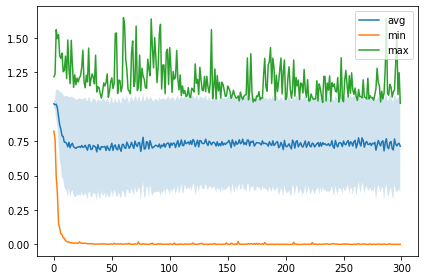

best
[-0.00856389 -0.01058178 -0.00186368 -0.02130009  0.00800848 -0.01332657
 -0.02281672  0.00440307  0.01527165  0.00016715]
speed
[-1.65911852  1.67986228  1.68050154  1.66747775  1.69695676  1.70029902
  1.685445   -1.7012924  -1.68078366  1.66589668]


In [31]:
pso_exp = PSOAlgorithm(pop_size, iterations, dimension, optimization_function)
pop, logbook, best = pso_exp.run()
print("best")
print(best)
print("speed")
print(pop[0].speed)

# 3. Сравнение эффективностей алгоритмов

gen	nevals	avg  	std      	min     	max    
0  	100   	1.019	0.0417129	0.622947	1.06522
1  	80    	1.00074	0.0675204	0.623238	1.02721
2  	80    	0.95759	0.122184 	0.623238	1.01835
3  	80    	0.833215	0.171509 	0.621755	1.0107 
4  	80    	0.677656	0.114065 	0.528819	1.00511
5  	80    	0.59208 	0.0402759	0.460361	0.678178
6  	80    	0.540557	0.0484017	0.433061	0.623238
7  	80    	0.486892	0.042452 	0.402996	0.573691
8  	80    	0.443667	0.0332022	0.345847	0.526869
9  	80    	0.403292	0.0348654	0.345847	0.486406
10 	80    	0.362686	0.0305108	0.266415	0.439669
11 	80    	0.322993	0.0489322	0.133982	0.384479
12 	80    	0.276962	0.069604 	0.133982	0.37769 
13 	80    	0.206355	0.060055 	0.112774	0.318826
14 	80    	0.153824	0.0403222	0.0954103	0.266002
15 	80    	0.124088	0.0256932	0.0875649	0.228631
16 	80    	0.106309	0.0162005	0.0829356	0.149901
17 	80    	0.0974919	0.0124067	0.0753161	0.160987
18 	80    	0.08852  	0.00957496	0.062133 	0.124799
19 	80    	0.0825042	0.00952887	0.0611553	0.12

155	80    	0.0088268 	0.0036414  	0.00818743	0.0311529
156	80    	0.0102571 	0.00876737 	0.00818743	0.0637192
157	80    	0.0102589 	0.00813074 	0.00818743	0.0480589
158	80    	0.00903791	0.00625362 	0.00818743	0.0642489
159	80    	0.00905434	0.00459672 	0.00818743	0.0380622
160	80    	0.00838274	0.00194328 	0.00818743	0.0277181
161	80    	0.00848423	0.00295315 	0.00818743	0.0378677
162	80    	0.0104294 	0.00840579 	0.00818743	0.048894 
163	80    	0.010369  	0.00877651 	0.00818743	0.0628872
164	80    	0.00934261	0.00648881 	0.00818743	0.0619862
165	80    	0.00844996	0.00261209 	0.00818743	0.03444  
166	80    	0.00902112	0.00425058 	0.00818743	0.0386504
167	80    	0.0102055 	0.00861711 	0.00818743	0.0589416
168	80    	0.00862975	0.004401   	0.00818743	0.0524191
169	80    	0.00946759	0.00630453 	0.00818743	0.0506547
170	80    	0.00883   	0.00467144 	0.00818743	0.0492341
171	80    	0.00884852	0.00506808 	0.00818743	0.0558546
172	80    	0.00839441	0.00205946 	0.00818743	0.0288858
173	80    

302	80    	0.00847558	0.00286702 	0.00818743	0.0370021 
303	80    	0.00924541	0.00637389 	0.00818743	0.0594581 
304	80    	0.0093809 	0.00575279 	0.00818743	0.0528893 
305	80    	0.00916866	0.00423544 	0.00818743	0.0331636 
306	80    	0.00886221	0.00461936 	0.00818743	0.0499711 
307	80    	0.00818743	0          	0.00818743	0.00818743
308	80    	0.00879671	0.00301617 	0.00818743	0.0260129 
309	80    	0.00918766	0.00600207 	0.00818743	0.0545059 
310	80    	0.00863373	0.00319764 	0.00818743	0.0353247 
311	80    	0.00904363	0.00533239 	0.00818743	0.0542977 
312	80    	0.00962147	0.00833701 	0.00818743	0.0681964 
313	80    	0.0088626 	0.0048295  	0.00818743	0.0489708 
314	80    	0.00853316	0.00343994 	0.00818743	0.0427602 
315	80    	0.00831683	0.00128752 	0.00818743	0.0211275 
316	80    	0.0088478 	0.00463788 	0.00818743	0.0438646 
317	80    	0.00886738	0.00499627 	0.00818743	0.0529284 
318	80    	0.00884563	0.00404259 	0.00818743	0.042257  
319	80    	0.00887676	0.00487024 	0.00818743	0.0

448	80    	0.00886604	0.00398169 	0.00818743	0.034956  
449	80    	0.00818743	0          	0.00818743	0.00818743
450	80    	0.00888942	0.00432878 	0.00818743	0.0449955 
451	80    	0.00940889	0.00773769 	0.00818743	0.0745417 
452	80    	0.00905569	0.0052498  	0.00818743	0.0484625 
453	80    	0.00854094	0.00247613 	0.00818743	0.0264832 
454	80    	0.00968709	0.00940375 	0.00818743	0.0878521 
455	80    	0.00898827	0.00461017 	0.00818743	0.0378171 
456	80    	0.00985431	0.00738344 	0.00818743	0.0507194 
457	80    	0.00905611	0.00500573 	0.00818743	0.0436481 
458	80    	0.00818743	0          	0.00818743	0.00818743
459	80    	0.0103478 	0.00820044 	0.00818743	0.0547893 
460	80    	0.0095352 	0.00606005 	0.00818743	0.0455875 
461	80    	0.00877114	0.00366141 	0.00818743	0.0372859 
462	80    	0.00992484	0.00876972 	0.00818743	0.0675109 
463	80    	0.0089358 	0.00403435 	0.00818743	0.0395327 
464	80    	0.00843587	0.00247198 	0.00818743	0.0330318 
465	80    	0.00952126	0.0067062  	0.00818743	0.0

116	100  	0.653148	0.329637 	0.0295052 	1.09617
117	100  	0.747162	0.328274 	0.0164354 	1.25357
118	100  	0.777705	0.311243 	0.0519783 	1.26494
119	100  	0.699791	0.333261 	0.00930606	1.0712 
120	100  	0.682207	0.339341 	0.0470232 	1.09452
121	100  	0.718278	0.333962 	0.0110074 	1.27227
122	100  	0.763586	0.319973 	0.0173629 	1.20328
123	100  	0.706214	0.32785  	0.0325689 	1.1493 
124	100  	0.707909	0.349896 	0.00939618	1.21893
125	100  	0.736701	0.315807 	0.0163528 	1.16648
126	100  	0.710389	0.32139  	0.0338141 	1.09075
127	100  	0.727088	0.338918 	0.0358839 	1.21378
128	100  	0.71611 	0.338559 	0.00985025	1.25863
129	100  	0.761415	0.322457 	0.0659943 	1.10771
130	100  	0.699372	0.349561 	0.0128583 	1.10219
131	100  	0.713367	0.326234 	0.0153197 	1.16344
132	100  	0.802361	0.278071 	0.0518135 	1.22736
133	100  	0.71164 	0.337529 	0.0109656 	1.27001
134	100  	0.685287	0.35075  	0.010599  	1.10258
135	100  	0.75427 	0.290535 	0.0494676 	1.22579
136	100  	0.760985	0.338259 	0.0234592 	

293	100  	0.673163	0.333917 	0.0173968 	1.26604
294	100  	0.713884	0.327352 	0.0272728 	1.19902
295	100  	0.761588	0.314088 	0.0335944 	1.17887
296	100  	0.668537	0.346129 	0.00914732	1.16057
297	100  	0.712175	0.337052 	0.0249094 	1.18096
298	100  	0.778373	0.310299 	0.0485906 	1.1739 
299	100  	0.724532	0.343342 	0.0481591 	1.21757
300	100  	0.707071	0.318004 	0.0378786 	1.24909
301	100  	0.717205	0.32304  	0.047559  	1.19967
302	100  	0.787333	0.313149 	0.0241321 	1.12784
303	100  	0.767312	0.308478 	0.0491289 	1.1478 
304	100  	0.677798	0.354901 	0.0261475 	1.32344
305	100  	0.70535 	0.344984 	0.0128421 	1.30517
306	100  	0.801158	0.290119 	0.0966296 	1.07891
307	100  	0.715904	0.341843 	0.0220175 	1.20672
308	100  	0.707667	0.30856  	0.0882609 	1.268  
309	100  	0.759293	0.320308 	0.0170908 	1.08296
310	100  	0.792068	0.31135  	0.00934774	1.11126
311	100  	0.663861	0.350129 	0.04562   	1.06202
312	100  	0.733038	0.332336 	0.00917017	1.27005
313	100  	0.783576	0.296476 	0.0348388 	

476	100  	0.67619 	0.320579 	0.0483847 	1.08999
477	100  	0.739065	0.322802 	0.0594232 	1.1087 
478	100  	0.709106	0.323774 	0.0276534 	1.11143
479	100  	0.722408	0.318404 	0.0643777 	1.08624
480	100  	0.708991	0.325    	0.0556157 	1.05994
481	100  	0.71775 	0.32774  	0.042995  	1.16731
482	100  	0.737833	0.329287 	0.0182824 	1.28909
483	100  	0.691345	0.333157 	0.0138649 	1.17483
484	100  	0.717738	0.314274 	0.0867868 	1.0609 
485	100  	0.674884	0.35002  	0.042108  	1.11165
486	100  	0.683297	0.340315 	0.0105289 	1.32029
487	100  	0.784935	0.278601 	0.033059  	1.32435
488	100  	0.712145	0.360868 	0.0312242 	1.29169
489	100  	0.685027	0.319931 	0.0301675 	1.154  
490	100  	0.725761	0.320155 	0.071401  	1.29299
491	100  	0.77171 	0.319425 	0.074782  	1.41709
492	100  	0.721518	0.33944  	0.034854  	1.53044
493	100  	0.654358	0.338163 	0.0476127 	1.15433
494	100  	0.779207	0.305425 	0.0361385 	1.15196
495	100  	0.762058	0.323224 	0.0651187 	1.18105
496	100  	0.649926	0.33604  	0.0454195 	

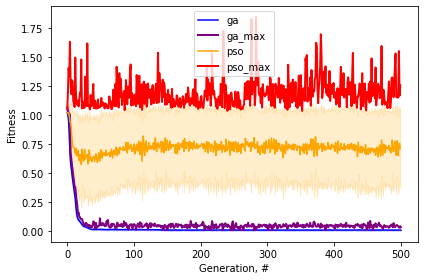

In [32]:
dimension = 10
pop_size = 100
iterations = 500
ga = GeneticAlgorithm(factory, optimization_function, pop_size, mutation = Mymutation, dimension=dimension)
population, log = ga.run_evolution(cross_prob, mut_prob, iterations, verbose=False)

pso = PSOAlgorithm(pop_size, iterations, dimension, optimization_function)
pop, logbook, best = pso.run(verbose=False)
DrawLog.draw_logs(log, logbook, "ga", "pso")